# Credit Card Fraud

Develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

raw_data = pd.read_csv('./data/creditcard.csv')
raw_data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  
3  0.647376 -0.221929  0.062723  0.061458  123.50      0  
4 -0.206010  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

## Data Exploration

In [2]:
frauds_count = raw_data.groupby('Class').count()[raw_data.columns[0]].iloc[1]
okay_count = raw_data.groupby('Class').count()[raw_data.columns[0]].iloc[0]

baseline = 1 - frauds_count / (frauds_count + okay_count)
print('Frauds:', frauds_count)
print('Not Frauds:', okay_count)
print('Baseline R-squared:', baseline)

Frauds: 492
Not Frauds: 284315
Baseline R-squared: 0.9982725143693799


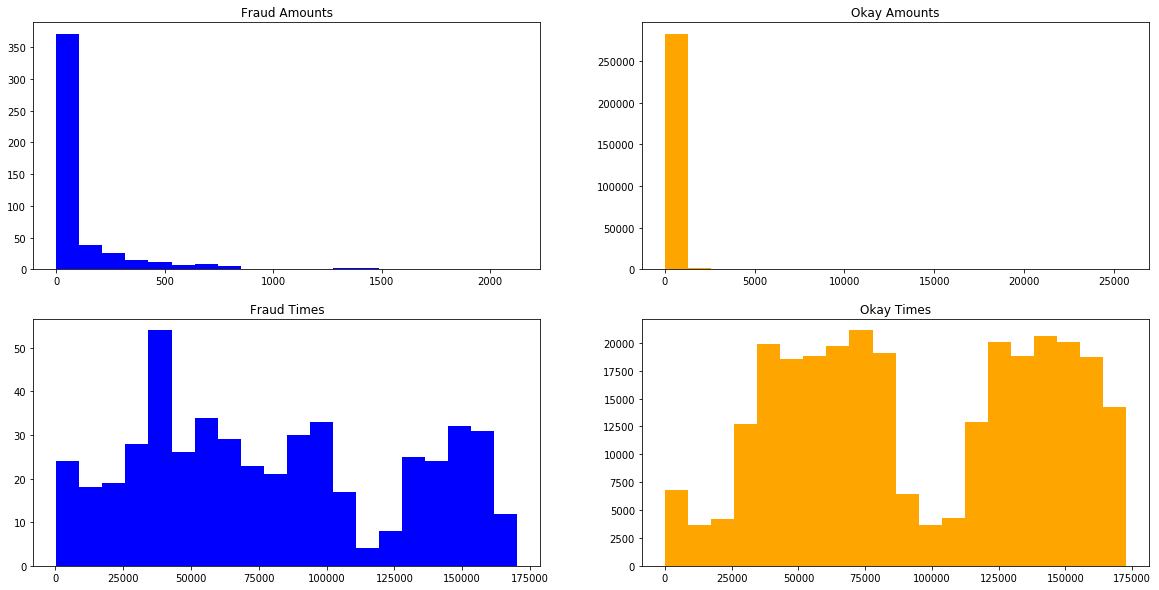

In [3]:
frauds = raw_data[raw_data['Class'] == 1]
okays = raw_data[raw_data['Class'] == 0]

plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.title('Fraud Amounts')
plt.hist(frauds['Amount'], bins=20, label='Fraud', color='blue')

plt.subplot(2, 2, 2)
plt.title('Okay Amounts')
plt.hist(okays['Amount'], bins=20, label='Okay', color='orange')

plt.subplot(2, 2, 3)
plt.title('Fraud Times')
plt.hist(frauds['Time'], bins=20, label='Fraud', color='blue')

plt.subplot(2, 2, 4)
plt.title('Okay Times')
plt.hist(okays['Time'], bins=20, label='Okay', color='orange')

plt.show()

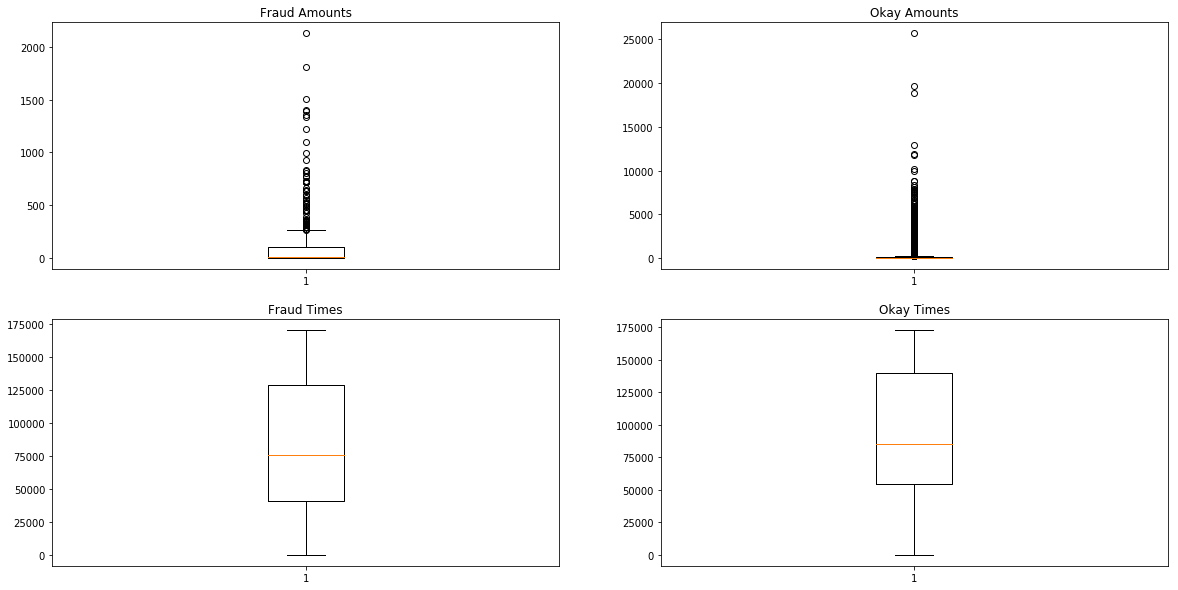

In [4]:
# TODO: 
# Try taking out outliers – see distribution of remaining amounts
# Compare model with / without outliers

plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.title('Fraud Amounts')
plt.boxplot(frauds['Amount'])

plt.subplot(2, 2, 2)
plt.title('Okay Amounts')
plt.boxplot(okays['Amount'])

plt.subplot(2, 2, 3)
plt.title('Fraud Times')
plt.boxplot(frauds['Time'])

plt.subplot(2, 2, 4)
plt.title('Okay Times')
plt.boxplot(okays['Time'])

plt.show()

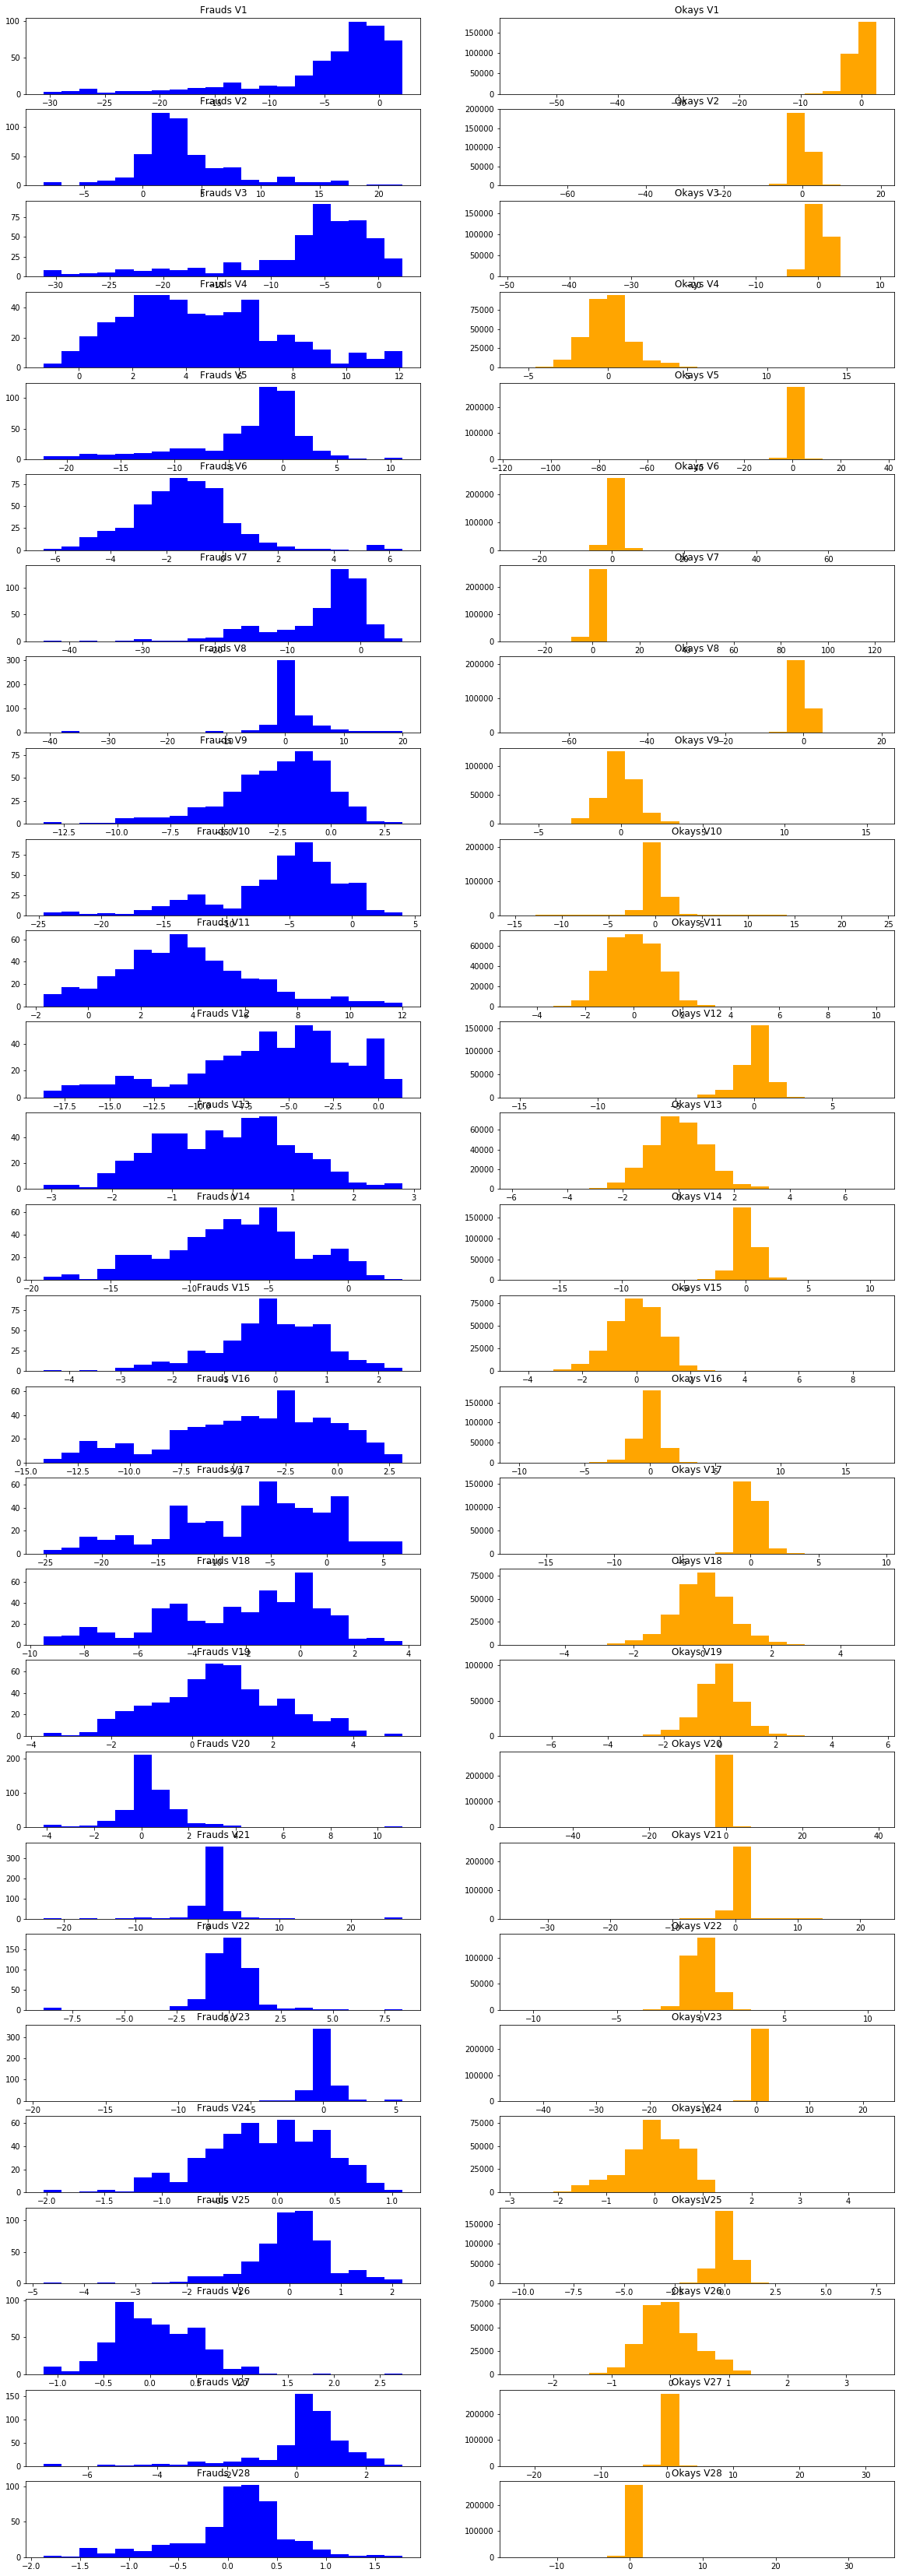

In [5]:
plt.figure(figsize=(20,60))

for i in range(28):
    col_name = 'V' + str(i + 1)
    
    plt.subplot(28, 2, 2 * i + 1)
    plt.title('Frauds ' + col_name)
    plt.hist(frauds[col_name], bins=20, color='blue')
    
    plt.subplot(28, 2, 2 * i + 2)
    plt.title('Okays ' + col_name)
    plt.hist(okays[col_name], bins=20, color='orange')
    
plt.show()

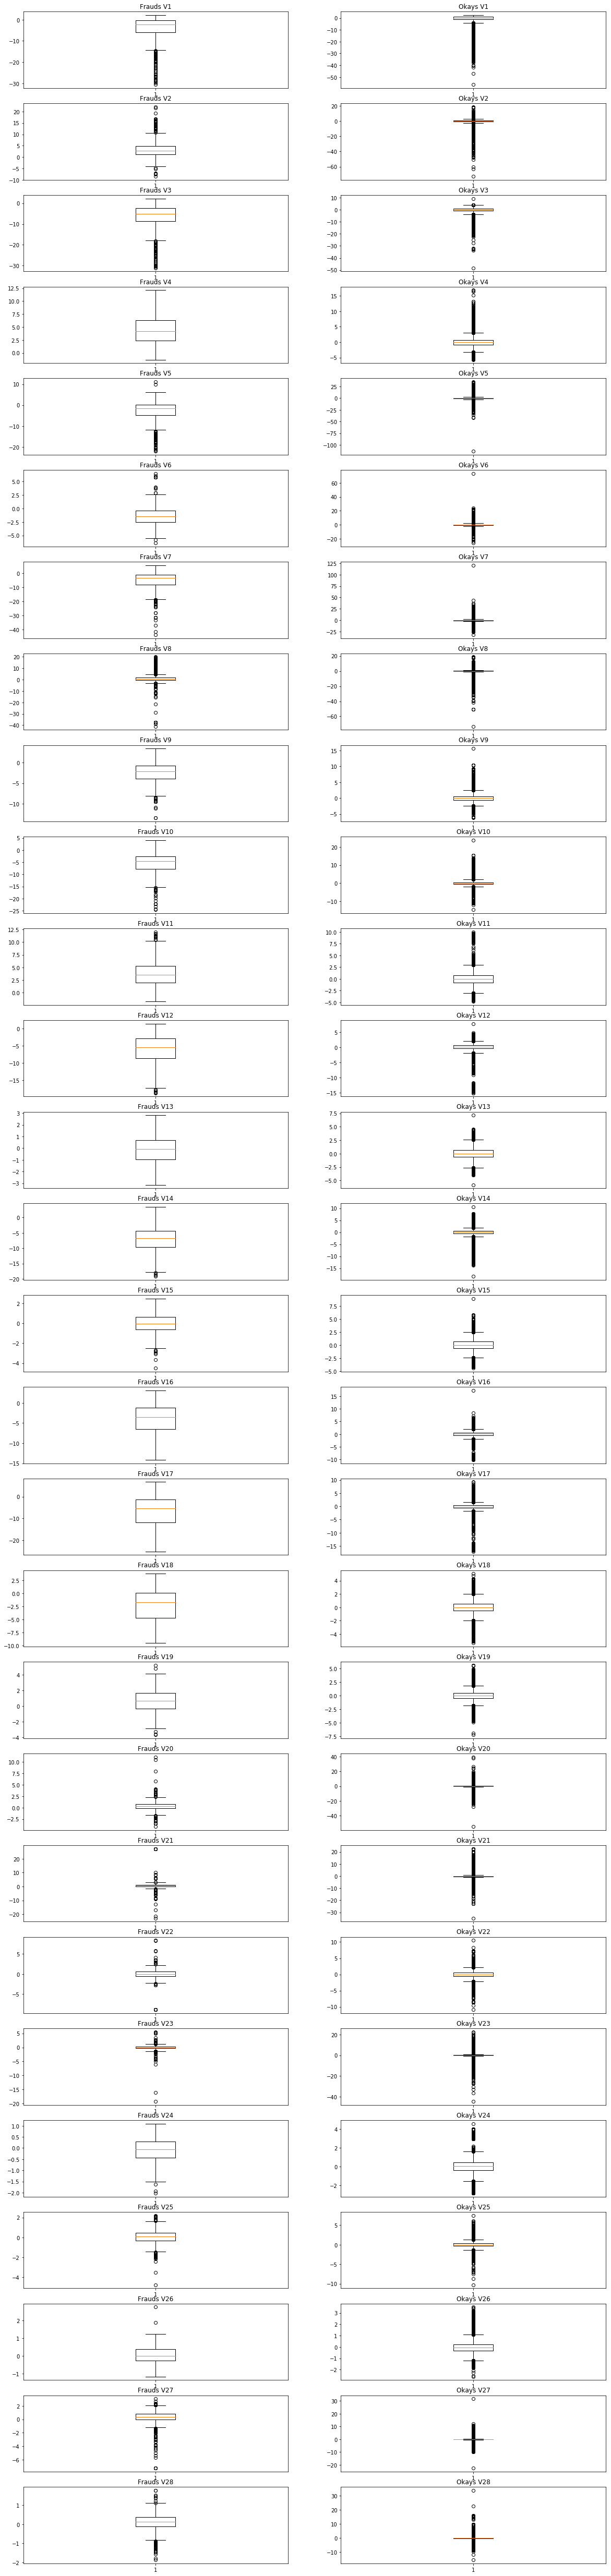

In [6]:
plt.figure(figsize=(20,90))

for i in range(28):
    col_name = 'V' + str(i + 1)
    
    plt.subplot(28, 2, 2 * i + 1)
    plt.title('Frauds ' + col_name)
    plt.boxplot(frauds[col_name])
    
    plt.subplot(28, 2, 2 * i + 2)
    plt.title('Okays ' + col_name)
    plt.boxplot(okays[col_name])
    
plt.show()

I am looking to minimize Type II errors ("false negative"s – i.e. considering something that is a fraud as okay). But before I begin to build models, I need to make sure my data is not skewed. There are 2 methods to correct this – undersampling my majority group (not-frauds) or oversampling my minority group (frauds). 

## STRATEGY 1: Undersampling Not-Frauds to Predict Frauds

In [7]:
print('Will randomly sample', frauds_count, '(# of frauds) random rows from "not-frauds" table')
undersampled_okays = okays.sample(n=frauds_count)
df = pd.concat([frauds, undersampled_okays])
df = df.reset_index()
df.head()

Will randomly sample 492 (# of frauds) random rows from "not-frauds" table


index    Time        V1        V2        V3        V4        V5        V6  \
0    541   406.0 -2.312227  1.951992 -1.609851  3.997906 -0.522188 -1.426545   
1    623   472.0 -3.043541 -3.157307  1.088463  2.288644  1.359805 -1.064823   
2   4920  4462.0 -2.303350  1.759247 -0.359745  2.330243 -0.821628 -0.075788   
3   6108  6986.0 -4.397974  1.358367 -2.592844  2.679787 -1.128131 -1.706536   
4   6329  7519.0  1.234235  3.019740 -4.304597  4.732795  3.624201 -1.357746   

         V7        V8  ...         V21       V22       V23       V24  \
0 -2.537387  1.391657  ...    0.517232 -0.035049 -0.465211  0.320198   
1  0.325574 -0.067794  ...    0.661696  0.435477  1.375966 -0.293803   
2  0.562320 -0.399147  ...   -0.294166 -0.932391  0.172726 -0.087330   
3 -3.496197 -0.248778  ...    0.573574  0.176968 -0.436207 -0.053502   
4  1.713445 -0.496358  ...   -0.379068 -0.704181 -0.656805 -1.632653   

        V25       V26       V27       V28  Amount  Class  
0  0.044519  0.177840  0.261145 -0.143276    0.00      1  
1  0.279798 -0.145362 -0.252773  0.035764  529.00      1  
2 -0.156114 -0.542628  0.039566 -0.153029  239.93      1  
3  0.252405 -0.657488 -0.827136  0.849573   59.00      1  
4  1.488901  0.566797 -0.010016  0.146793    1.00      1  

[5 rows x 32 columns]

In [8]:
df_test = df.iloc[::2]
df_train = df.iloc[1::2]

# TRAINING
X_train = df_train.loc[:, ~(df_train.columns).isin(['Class'])]
Y_train = df_train['Class'].values.reshape(-1, 1)

# TESTING
X_test = df_test.loc[:, ~(df_train.columns).isin(['Class'])]
Y_test = df_test['Class'].values.reshape(-1, 1)

### LASSO Logistic Regression

In [9]:
def fit_and_train(model, fit_X_train, fit_Y_train, X_train, Y_train):
    model_fit = model.fit(fit_X_train, fit_Y_train)
    model_score_train = model.score(X_train, Y_train)
    print('R² for train:', model_score_train)
    
    model_score_test = model.score(X_test, Y_test)
    print('\nR² for test:', model_score_test)
    
    model_improve_over_baseline = (model_score_test - baseline) / baseline
    print('Improvement over baseline:', model_improve_over_baseline)
    
    if hasattr(model_fit, 'coef_'):
        print('\nCoefficients:', model_fit.coef_)
    
    if hasattr(model_fit, 'intercept_'):
        print('\nIntercept:', model_fit.intercept_)
    
    if hasattr(X_train, 'columns'):
        print('Data cols:', list(X_train.columns))

lasso = linear_model.LogisticRegression(penalty='l1', C=100) 
fit_and_train(lasso, X_train, Y_train, X_train, Y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R² for train: 0.9471544715447154

R² for test: 0.9491869918699187
Improvement over baseline: -0.049170463769073185

Coefficients: [[ 4.04606622e-05 -8.63552243e-05  4.53466183e+00  8.81398864e+00
   2.32123542e+00  1.90167462e-01  5.49998276e+00 -4.04693656e+00
  -9.38633763e+00  2.70248410e-01 -1.30126858e+00 -2.56427825e+00
   3.33499009e+00 -6.51164137e+00 -8.51372853e-01 -8.14706225e+00
  -7.91220872e-01 -6.32471178e+00 -9.83013887e+00 -3.70498401e+00
   2.37046713e+00 -4.24849890e+00 -7.68356957e-01  3.04804478e+00
   9.05356956e+00 -6.40241913e-01  3.04848740e+00  5.39815697e-01
  -6.99244242e-01  5.03324835e+00  8.31729829e-02]]

Intercept: [-9.69117257]
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


#### Evaluating LASSO Logistic Regression

In [10]:
def evaluate_model_printout(model):
    Y_train_vals = df_train['Class'].values
    Y_test_vals = df_test['Class'].values

    predict_train = model.predict_proba(X_train)
    predict_train = list(map(lambda x: 0 if x[0] > .998 else 1, predict_train))
    predict_train = np.fromiter(predict_train, dtype=np.int)

    predict_test = model.predict_proba(X_test)
    predict_test = list(map(lambda x: 0 if x[0] > .998 else 1, predict_test))
    predict_test = np.fromiter(predict_test, dtype=np.int)
    
    crosstab_labels = [0, 1, 'All']
    table_train = pd.crosstab(Y_train_vals, predict_train, rownames=['actual'], colnames=['predicted'], margins=True)
    table_train = table_train.reindex(index=crosstab_labels,columns=crosstab_labels, fill_value=0)

    print('TRAIN:')
#     print(table_train, '\n')

    train_tI_errors = table_train.loc[0,1] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1,0] / table_train.loc['All','All']
    print(('Accuracy:\n% Type I errors: {}\n% Type II errors: {}\n').format(train_tI_errors, train_tII_errors))

    train_precision = table_train.loc[1,1] / table_train.loc['All', 1] # correctly predicted positives / all predicted positives
    train_recall = table_train.loc[1,1] / table_train.loc[1,'All'] # true positives / (true positives + false negatives)
    print('Precision:', train_precision)
    print('Recall:', train_recall, '\n\n----------\n')

    table_test = pd.crosstab(Y_test_vals, predict_test, rownames=['actual'], colnames=['predicted'], margins=True)
    table_test = table_test.reindex(index=crosstab_labels,columns=crosstab_labels, fill_value=0)
    
    print('TEST:')
#     print(table_test, '\n')

    test_tI_errors = table_test.loc[0,1]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1,0]/table_test.loc['All','All']
    print(('Accuracy:\n% Type I errors: {}\n% Type II errors: {}\n').format(test_tI_errors, test_tII_errors))

    test_precision = table_test.loc[1,1] / table_test.loc['All', 1] # correctly predicted positives / all predicted positives
    test_recall = table_test.loc[1,1] / table_test.loc[1,'All'] # true positives / (true positives + false negatives)
    print('Precision:', test_precision)
    print('Recall:', test_recall)

evaluate_model_printout(lasso)

TRAIN:
Accuracy:
% Type I errors: 0.40853658536585363
% Type II errors: 0.0

Precision: 0.5503355704697986
Recall: 1.0 

----------

TEST:
Accuracy:
% Type I errors: 0.39634146341463417
% Type II errors: 0.0020325203252032522

Precision: 0.5568181818181818
Recall: 0.9959349593495935


I am looking to minimize Type II errors ("false negative"s – i.e. considering something that is a fraud as okay). My test set gave 0.0% for Type II errors, which I am very happy with, especially since my percentage of Type I errors is also extremely low (~0.000035%).

In [11]:
# NOTE: Could use ROC / AUC threshold for less performant classifiers

### Ridge Logistic Regression

In [12]:
ridge = linear_model.LogisticRegression(penalty='l2', C=100, fit_intercept=False)
fit_and_train(ridge, X_train, Y_train, X_train, Y_train)

R² for train: 0.9390243902439024

R² for test: 0.9410569105691057
Improvement over baseline: -0.05731461397233599

Coefficients: [[ 5.16415178e-05 -1.05346219e-04 -2.96414243e-02  2.21101979e-01
  -2.59292364e-01  5.01517227e-01  5.33997608e-02 -1.22651151e-01
  -1.08231324e-01 -2.20905981e-01 -1.49141395e-01 -1.79489226e-01
   1.51578005e-01 -3.00260359e-01 -1.16908833e-01 -5.62383275e-01
  -3.22258496e-02 -8.48848162e-02  9.01627377e-03  5.04873569e-02
  -4.55281906e-03  6.89487803e-02  9.44572191e-02  9.33748723e-02
   6.46027597e-02 -5.41709712e-03 -3.44726676e-02  9.50725051e-03
  -7.16871071e-03  9.32187335e-03  1.85438114e-03]]

Intercept: 0.0
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


I am less happy with the ridge regression's R² value here, as it is only a 0.04% improvement on baseline.

#### Evaluating Ridge Logistic Regression

In [13]:
evaluate_model_printout(ridge)

TRAIN:
Accuracy:
% Type I errors: 0.5
% Type II errors: 0.0

Precision: 0.5
Recall: 1.0 

----------

TEST:
Accuracy:
% Type I errors: 0.5
% Type II errors: 0.0

Precision: 0.5
Recall: 1.0


### Gradient Boosting Classifier

In [14]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm, X_train, Y_train, X_train, Y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R² for train: 1.0

R² for test: 0.9308943089430894
Improvement over baseline: -0.06749480172641441
Data cols: ['index', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


#### Evaluating Gradient Boosting Classifier

In [15]:
evaluate_model_printout(gbm)

TRAIN:
Accuracy:
% Type I errors: 0.12804878048780488
% Type II errors: 0.0

Precision: 0.7961165048543689
Recall: 1.0 

----------

TEST:
Accuracy:
% Type I errors: 0.2032520325203252
% Type II errors: 0.0020325203252032522

Precision: 0.7101449275362319
Recall: 0.9959349593495935


### Support Vector Machine

In [ ]:
svm = SVC(kernel='linear', probability=True)
fit_and_train(svm, X_train, Y_train, X_train, Y_train)

#### Evaluating Support Vector Machine

In [ ]:
evaluate_model_printout(svm)

### Random Forest Classifier

In [ ]:
rfc = ensemble.RandomForestClassifier()
fit_and_train(rfc, X_train, Y_train, X_train, Y_train)

#### Evaluating Random Forest Classifier

In [ ]:
evaluate_model_printout(rfc)

### Naive Bayes

In [ ]:
bnb = BernoulliNB()
fit_and_train(bnb, X_train, Y_train, X_train, Y_train)

#### Evaluating Naive Bayes

In [ ]:
evaluate_model_printout(bnb)

## STRATEGY 2: Over-Sampling Frauds

In [ ]:
df_test = raw_data.iloc[::2]
df_train = raw_data.iloc[1::2]

X_train = df_train.loc[:, ~(df_train.columns).isin(['Class'])]
Y_train = df_train['Class'].values.reshape(-1, 1)

# TESTING
X_test = df_test.loc[:, ~(df_train.columns).isin(['Class'])]
Y_test = df_test['Class'].values.reshape(-1, 1)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

### LASSO Logistic Regression

In [ ]:
lasso = linear_model.LogisticRegression(penalty='l1', C=100) 
fit_and_train(lasso, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating LASSO Logistic Regression

In [ ]:
evaluate_model_printout(lasso)

### Ridge Logistic Regression

In [ ]:
ridge = linear_model.LogisticRegression(penalty='l2', C=100, fit_intercept=False)
fit_and_train(ridge, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating Ridge Logistic Regression

In [ ]:
evaluate_model_printout(ridge)

### Gradient Boosting Classifier

In [ ]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
fit_and_train(gbm, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating Gradient Boosting Classifier

In [ ]:
evaluate_model_printout(gbm)

### Support Vector Machine

In [ ]:
svm = SVC(kernel = 'linear', probability=True)
fit_and_train(svm, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating Support Vector Machine

In [ ]:
evaluate_model_printout(svm)

### Random Forest Classifier

In [ ]:
rfc = ensemble.RandomForestClassifier()
fit_and_train(rfc, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating Random Forest Classifier

In [ ]:
evaluate_model_printout(rfc)

### Naive Bayes

In [ ]:
bnb = BernoulliNB()
fit_and_train(bnb, X_train_res, Y_train_res, X_train, Y_train)

#### Evaluating Naive Bayes

In [ ]:
evaluate_model_printout(bnb)

## Conclusion

Of all the classifiers used, the Naive Bayes model was the most performant, as it 1) minimized errors, especially Type II errors, and 2) showed a high precision and recall rate.

In [ ]:
# MENTOR NOTES:
# Precision – % of my + predictions that are correct
# Recall – % of my target +s I predicted


# CURRICULUM NOTES:
# There are a few things you can do to deal with class imbalance:

# Ignore. If we really only care about the absolute accuracy of the model and our sample is representative of the population, 
# this can be a reasonable strategy. Engineer features that strongly identify the minority class, and this can turn out ok.

# Change your sampling. If you oversample the minority class or undersample the majority class, you can create a more balanced training set. 
# This is particularly useful if the goal of your model is to correctly identify the minority class. This can also be done by creating synthetic samples 
# to try to make your data more balanced or weighting samples to balance out your classes. 

# Probability outputs. 
# Although Naive Bayes' probability outputs are generally inaccurate, other models will give you a more accurate probability of a certain class. 
# e.g. logistic regression or support vector machines (SVM)
# Instead of just taking the most likely outcome, you can set up a specific cutoff or a more complex rule. 
# In the binary case, it could be going with the minority case if it has a priority greater than some threshold.

# Lastly, you can create cost functions for errors. This quantifies ways in which errors are not equal – scale the cost of an error up or down. 
# This can mean something like a Type II error being twice as bad as a Type I error, or however you choose to quantify that relationship. 
# SKLearn's Naive Bayes model does not have an easy built-in way to do this, but it's a good thing to keep in mind.